In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import json
import csv

%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

In [2]:
with open("boxofficemojo_final_dictionary.json", "rb") as json_file:
    main_dict = json.load(json_file)

In [3]:
#destroys main_dict so need to reload the above every time before running this
single_headers = ['title', 'runtime', 'rating', 'studio','opening date', 'opening gross', 'opening theaters', 
 'total gross', 'total theaters', 'boxofficemojo url']
genrelist = []
actorlist = []
singlevaluedict = {}
for title, movie in main_dict.iteritems():
    if 'genres' in movie: genrelist.append([title] + movie.pop('genres'))
    if 'actors' in movie: actorlist.append([title] + movie.pop('actors'))
    singlevaluedict.update({title: [movie.get(header,'unknown') for header in single_headers]})

##Genres

In [4]:
mylist=[]
for row in genrelist:
    for values in row:
        if row[0] != values:
            mylist.append([row[0], values])
genre_df = pd.DataFrame(mylist)
genre_df.columns = ['title', 'genre']
# genre_df['genre'].value_counts()

In [5]:
# with open("violent_categories_revised.txt", "rb") as f:
#     v_list = f.read().splitlines()

# v_genres = [i.strip() for i in v_list]

# violent_movies_by_genre = genre_df[(genre_df['genre'].isin(v_list))]
# score_list = []
# for item in genre_df['genre'].values.tolist():
#     if item in v_genres:
#         score_list.append(3)
#     else:
#         score_list.append(1)
##make new rating with multiplication and rated genres
genre_scores = {}
with open("violent_categories_revised_dict.txt", "rb") as f:
    for i in f:
        genre_scores.update(eval(i))

#add the score column with scores
genre_score_list = []
for item in genre_df['genre'].values.tolist():
    if item in genre_scores:
        genre_score_list.append(genre_scores[item])
    else:
        genre_score_list.append(1)
genre_df['genre score'] = genre_score_list
# genre_scored_movies[(genre_df['title'] == 'Kick-Ass')]

In [6]:
genre_scored_movies = genre_df.copy()
genre_scored_movies = genre_scored_movies.groupby('title').aggregate(np.prod)
# genre_scored_movies.sort('genre score', ascending=False)

##Rating

In [7]:
single_value_df = pd.DataFrame(singlevaluedict)
single_value_df = single_value_df.T
single_value_df.columns = single_headers
# single_value_df['rating'].value_counts()

In [8]:
#get all the rows where rating column equals 'n/a'
# single_value_df[(single_value_df['rating']=='n/a')]

In [9]:
rating_scores = {}
with open("ratings_rated.txt", "rb") as f:
    for i in f:
        rating_scores.update(eval(i))

#add the score column with scores
rating_score_list = []
for item in single_value_df['rating'].values.tolist():
    rating_score_list.append(rating_scores[item])
rating_scored_movies = single_value_df.copy()
rating_scored_movies['rating score'] = rating_score_list
# rating_scored_movies.sort('rating score', ascending=False)

##Body Count

In [10]:
with open("moviebodycounts_final_movie_data_second_clean.json", "rb") as json_file:
    body_count_dict = json.load(json_file)

In [11]:
body_count_df = pd.DataFrame(body_count_dict)
body_count_df = body_count_df.T.convert_objects(convert_numeric=True)
# body_count_df.sort('body count', ascending=False)

In [12]:
body_count_score_list = []
for item in single_value_df['title'].values.tolist():
    if item in body_count_dict:
        body_count_score_list.append(int(body_count_dict[item]['body count']))
    else:
        body_count_score_list.append(None)
body_count_scored_movies = single_value_df.copy()
body_count_scored_movies['body count score'] = body_count_score_list
# body_count_scored_movies.sort('body count score', ascending=False)

##Total Index

In [13]:
total_index = single_value_df.copy()
total_index['genre score'] = genre_scored_movies['genre score']
total_index['normalized genre score'] = genre_scored_movies['genre score'].div(512)
# total_index.sort('normalized genre score', ascending=False)
total_index['rating score'] = rating_scored_movies['rating score']
total_index['normalized rating score'] = rating_scored_movies['rating score'].div(7)
# body_count_scored_movies['body count score'].convert_objects(convert_numeric=True)
total_index['body count score'] = body_count_scored_movies['body count score']
total_index['normalized body count score'] =  body_count_scored_movies['body count score'].div(836)
total_index['violence index'] = total_index['normalized genre score'] + total_index['normalized rating score'] + total_index['normalized body count score']
total_index = total_index.dropna(subset=['genre score'])

In [14]:
test_series = total_index.groupby(['genre score']).mean()["body count score"]

test_indices = test_series.index
# print test_indices.tolist()
null_indices = [i for i, x in enumerate(test_series) if pd.isnull(x)]#test_series[pd.isnull(test_series)].index.tolist())]
# print null_indices
#print test_series.iloc[null_indices])
replacements = [x-1 for x in null_indices]
# print test_series.iloc[replacements]
# print 'replacements', replacements
# print 
# print test_series

#for i in total_index.groupby('genre score').mean()['body count score']:
#     if isnull(i):
# print 'worked?', test_series.replace(test_series.iloc[null_indices], test_series.iloc[replacements])
this_dict = dict(test_series)
this_dict[72] = 57.875
this_dict[96] = 37.0
this_dict[162] = 104.5
this_dict[192] = 104.5
this_dict[256] = 35.0
    
# this_dict

In [15]:
temp_list = [] 
headers = total_index.columns.values

for _, item in total_index.iterrows():#['title'].head(200):
#     {header:item[index] for index,header in enumerate(headers)}

    if pd.isnull(item['body count score']):
        genre_comparison_score = item['genre score']
        body_transfer = this_dict[genre_comparison_score]
        temp_list.append(body_transfer)
    else:
        temp_list.append(item['body count score'])
# temp_list

In [16]:
## replace body count score nan values interpolated by comparison to a similar movie
total_index['implied body count score'] = temp_list

In [17]:
total_index['normalized implied body count score'] = total_index['implied body count score'].div(836)
total_index['implied violence index'] = total_index['normalized genre score'] + total_index['normalized rating score'] + total_index['normalized implied body count score']

In [18]:
# total_index.sort('implied violence index', ascending=False)


In [19]:
total_index['violence rank'] = total_index['implied violence index'].rank(ascending=False)

In [20]:
# total_index.sort('implied violence index', ascending=False)

##Chicago is a wasteland

In [21]:
crime_df = pd.DataFrame.from_csv('Crimes_-_2001_to_present.csv', infer_datetime_format=True)
# crime_df

In [22]:
crime_df['day'] = pd.to_datetime(crime_df['Date'], format="%m/%d/%Y", exact=False, dayfirst=True)

In [23]:
# crime_df

In [24]:
v_crimes_per_day = crime_df.groupby('day').count()
v_crimes_per_day = v_crimes_per_day.reset_index()

In [25]:
# crime_df.dtypes

In [26]:
# total_index[(total_index['opening date'] == '9/26/2008')]


In [27]:
# ##error correction
# total_index = total_index[(total_index['opening date'] != 'Jun 1957')]
# total_index = total_index[(total_index['opening date'] != 'Jan 2013')]
# total_index = total_index[(total_index['opening date'] != 'TBD')]
# total_index = total_index[(total_index['opening date'] != '1966')]
# total_index = total_index[(total_index['opening date'] != '1987')]
# total_index = total_index[(total_index['opening date'] != 'Jun 1957')]

In [28]:
v_crimes_per_day = v_crimes_per_day.set_index('day')

In [29]:
v_crimes_per_day = v_crimes_per_day['Primary Type']

In [30]:
# v_crimes_per_day

In [31]:
total_index_graph = total_index.copy()
total_index_graph['opening date'] = pd.to_datetime(total_index_graph['opening date'], dayfirst=True, coerce=True)
total_index_graph = total_index_graph[(total_index_graph['opening date'].dt.year > 2000) & (total_index_graph['opening date'].dt.year < 2016)].sort('opening date')

v_movies_per_day = total_index_graph.groupby('opening date').sum()
v_movies_per_day = v_movies_per_day['implied violence index']
# v_movies_per_day = total_index_graph['implied violence index']

In [32]:
# total_index_graph

In [33]:
# v_movies_per_day

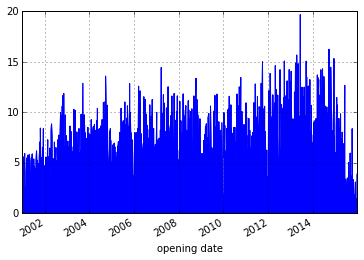

In [34]:
v_movies_per_day.plot(kind='area')

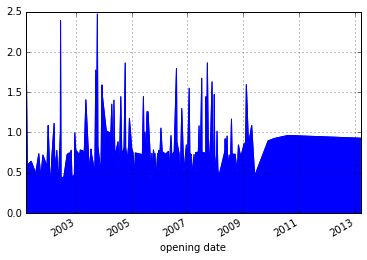

In [35]:
##graphs with nan values removed and not interpolated
no_nan_graph = total_index_graph.groupby('opening date').sum()
no_nan_graph = no_nan_graph['violence index'].dropna()
no_nan_graph.plot(kind='area')

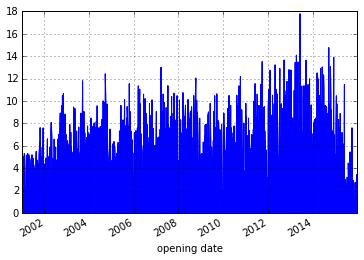

In [36]:
##graphs with nan values set to 1 and not interpolated
nan_1_graph = total_index_graph.groupby('opening date').sum()
nan_1_graph['body count score'] = nan_1_graph['body count score'].fillna(1)
nan_1_graph['normalized body count score'] =  nan_1_graph['body count score'].div(836)
nan_1_graph['violence index'] = nan_1_graph['normalized genre score'] + nan_1_graph['normalized rating score'] + nan_1_graph['normalized body count score']
nan_1_graph = nan_1_graph['violence index']
nan_1_graph.plot(kind='area')

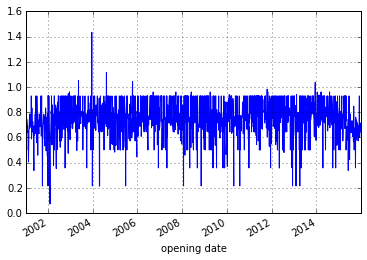

In [37]:
##original graph with the average violent movie rating for each day rather than the total violent movie rating per day
mean_graph = total_index_graph.groupby('opening date').mean()
mean_graph = mean_graph['implied violence index']
mean_graph.plot()

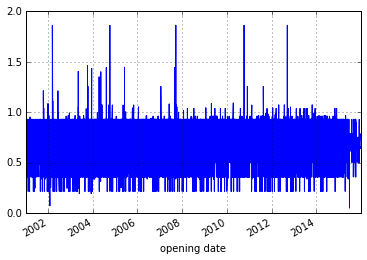

In [228]:
## each movie stands alone for each day alone rather than getting summed
stand_alone_graph = total_index_graph.copy()
stand_alone_graph = stand_alone_graph.set_index('opening date')
stand_alone_graph = stand_alone_graph['implied violence index']
stand_alone_graph.plot()

In [264]:
## each movie score extends out for seven days from the release date instead of just the opening date
import datetime
five_day_graph = total_index_graph.copy()
five_day_graph = five_day_graph.set_index(['title', 'opening date'])
new_rows = []
for row in five_day_graph.iterrows():
    for i in range(1,7):
        title , date = row[0]
        new_date = date + datetime.timedelta(days=i)
        new_row = five_day_graph.loc[(title, date)]
        new_row.name = (title, new_date)
        new_rows.append(new_row)
five_day_graph = five_day_graph.append(new_rows)
five_day_graph = five_day_graph.sort_index()


In [265]:
seven_day_graph = five_day_graph.copy()

In [266]:
five_day_graph = five_day_graph.reset_index()
five_day_graph_no_nan = five_day_graph.copy()

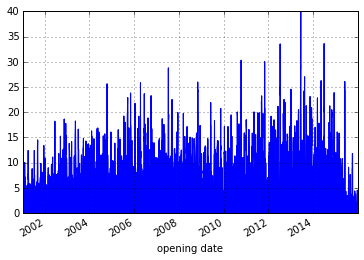

In [280]:
#7 day with interpolation
five_day_graph_i = five_day_graph.groupby('opening date').sum()
five_day_graph_i = five_day_graph_i['implied violence index']
five_day_graph_i.plot(kind='area')


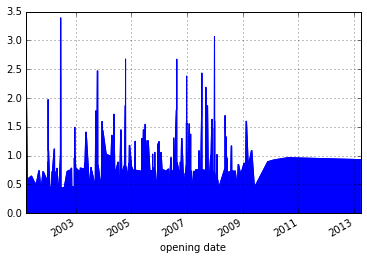

In [281]:
#7 day without interpolation
five_day_graph_no_nan = five_day_graph_no_nan.groupby('opening date').sum()
five_day_graph_no_nan = five_day_graph_no_nan['violence index'].dropna()
five_day_graph_no_nan.plot(kind='area')

In [275]:
# seven_day_graph

In [270]:
seven_day_graph = seven_day_graph.reset_index()
seven_day_graph_no_nan = seven_day_graph.copy()

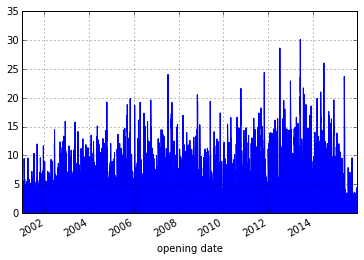

In [271]:
#7 day reducing with interpolation
seven_day_graph_i = seven_day_graph.groupby('opening date').sum()
seven_day_graph_i = seven_day_graph_i['reducing implied violence index']
seven_day_graph_i.plot(kind='area')


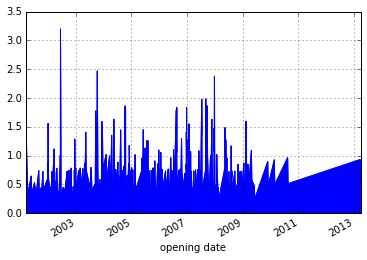

In [272]:
#7 day reducing without interpolation
seven_day_graph_no_nan = seven_day_graph_no_nan.groupby('opening date').sum()
seven_day_graph_no_nan = seven_day_graph_no_nan['reducing violence index'].dropna()
seven_day_graph_no_nan.plot(kind='area')

In [259]:
## meaning of life graph
# mol_graph = total_index_graph.groupby('opening date')
# mol_graph = mol_graph['implied violence index']
# mol_graph.plot(figsize=(20,5))

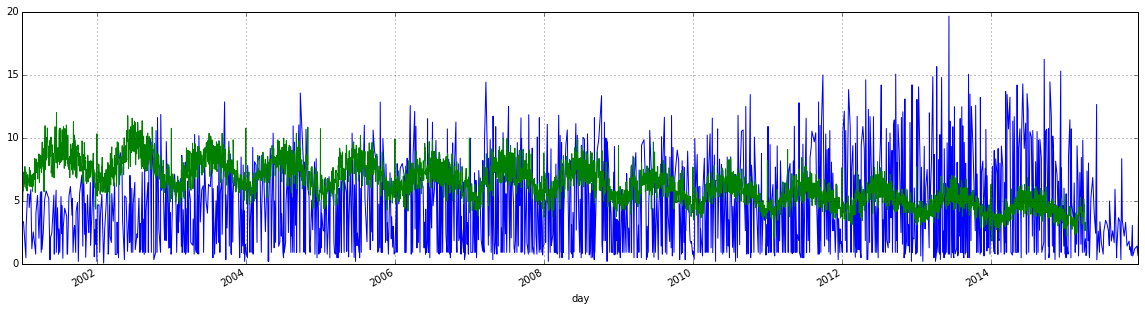

In [162]:
##original
v_movies_per_day.plot()
v_crimes_per_day.div(50).plot(figsize=(20,5))

In [276]:
five_day_graph_no_nan

,title,opening date,runtime,rating,studio,opening gross,opening theaters,total gross,total theaters,boxofficemojo url,...,normalized genre score,rating score,normalized rating score,body count score,normalized body count score,violence index,implied body count score,normalized implied body count score,implied violence index,violence rank
0,$9.99,2008-12-12,1 hrs. 18 min.,R,Reg.,$478,1,"$52,384",4,http://www.boxofficemojo.com/movies/?id=9dot99...,...,0.001953,5,0.714286,NaN,NaN,NaN,58.946809,0.070511,0.786749,7209.0
1,$9.99,2008-12-13,1 hrs. 18 min.,R,Reg.,$478,1,"$52,384",4,http://www.boxofficemojo.com/movies/?id=9dot99...,...,0.001953,5,0.714286,NaN,NaN,NaN,58.946809,0.070511,0.786749,7209.0
2,$9.99,2008-12-14,1 hrs. 18 min.,R,Reg.,$478,1,"$52,384",4,http://www.boxofficemojo.com/movies/?id=9dot99...,...,0.001953,5,0.714286,NaN,NaN,NaN,58.946809,0.070511,0.786749,7209.0
3,$9.99,2008-12-15,1 hrs. 18 min.,R,Reg.,$478,1,"$52,384",4,http://www.boxofficemojo.com/movies/?id=9dot99...,...,0.001953,5,0.714286,NaN,NaN,NaN,58.946809,0.070511,0.786749,7209.0
4,$9.99,2008-12-16,1 hrs. 18 min.,R,Reg.,$478,1,"$52,384",4,http://www.boxofficemojo.com/movies/?id=9dot99...,...,0.001953,5,0.714286,NaN,NaN,NaN,58.946809,0.070511,0.786749,7209.0
5,$9.99,2008-12-17,1 hrs. 18 min.,R,Reg.,$478,1,"$52,384",4,http://www.boxofficemojo.com/movies/?id=9dot99...,...,0.001953,5,0.714286,NaN,NaN,NaN,58.946809,0.070511,0.786749,7209.0
6,$9.99,2008-12-18,1 hrs. 18 min.,R,Reg.,$478,1,"$52,384",4,http://www.boxofficemojo.com/movies/?id=9dot99...,...,0.001953,5,0.714286,NaN,NaN,NaN,58.946809,0.070511,0.786749,7209.0
7,$upercapitalist,2012-10-08,1 hrs. 36 min.,Unrated,Truly,"$8,372",1,"$15,919",1,http://www.boxofficemojo.com/movies/?id=superc...,...,0.001953,6,0.857143,NaN,NaN,NaN,58.946809,0.070511,0.929607,2216.5
8,$upercapitalist,2012-10-09,1 hrs. 36 min.,Unrated,Truly,"$8,372",1,"$15,919",1,http://www.boxofficemojo.com/movies/?id=superc...,...,0.001953,6,0.857143,NaN,NaN,NaN,58.946809,0.070511,0.929607,2216.5
9,$upercapitalist,2012-10-10,1 hrs. 36 min.,Unrated,Truly,"$8,372",1,"$15,919",1,http://www.boxofficemojo.com/movies/?id=superc...,...,0.001953,6,0.857143,NaN,NaN,NaN,58.946809,0.070511,0.929607,2216.5


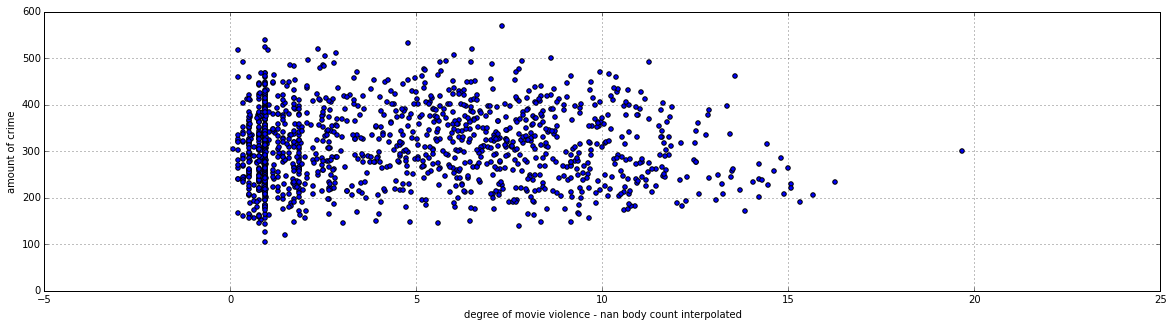

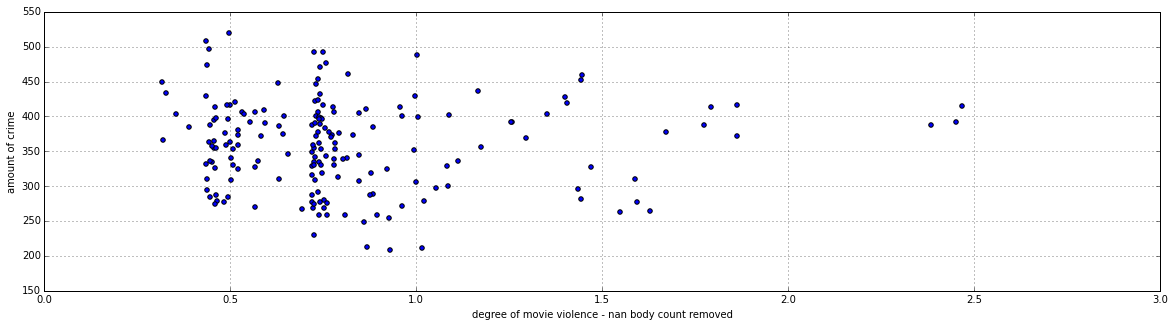

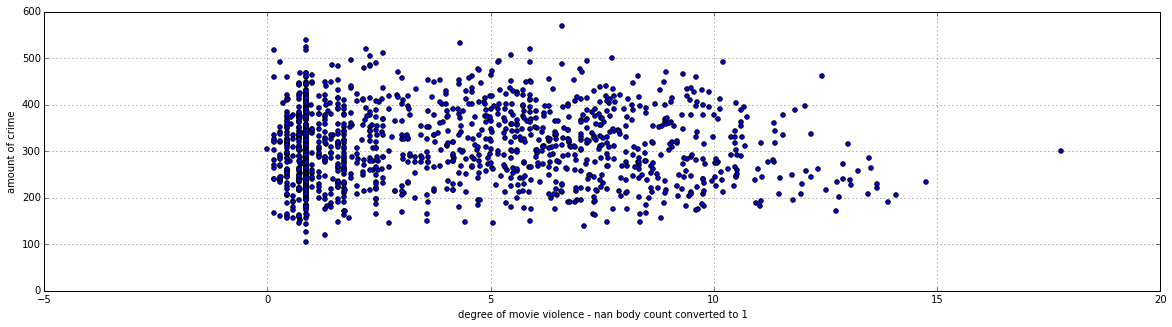

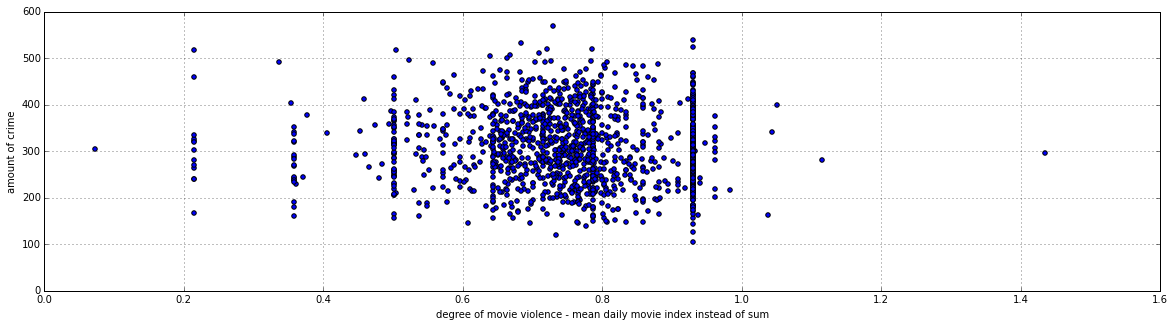

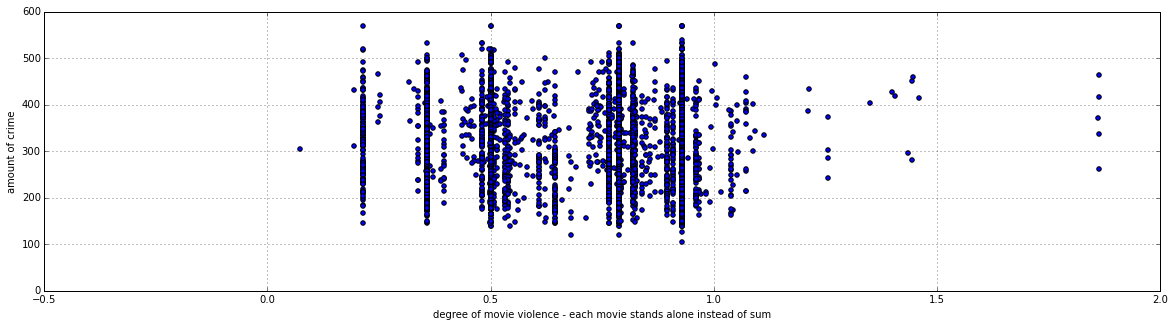

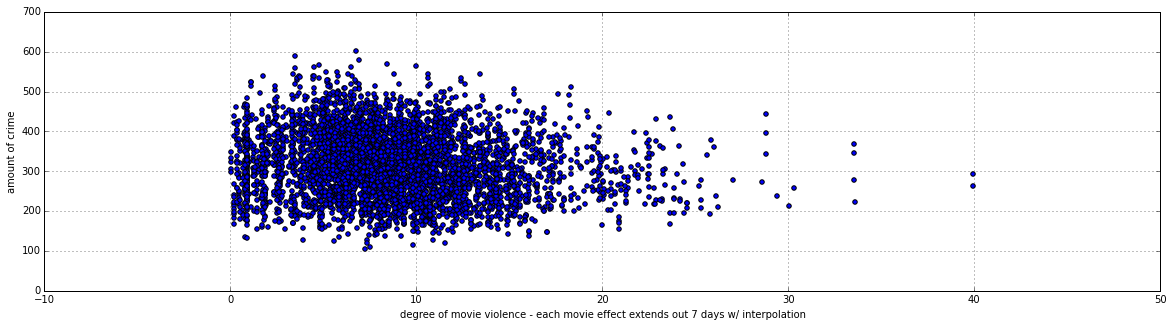

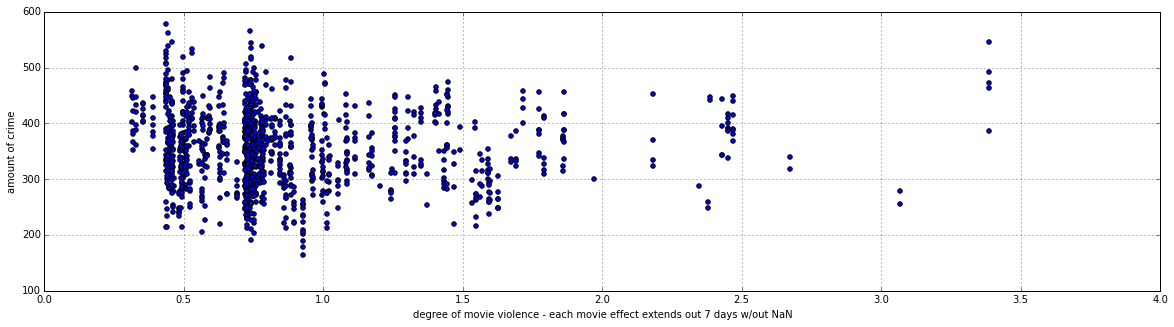

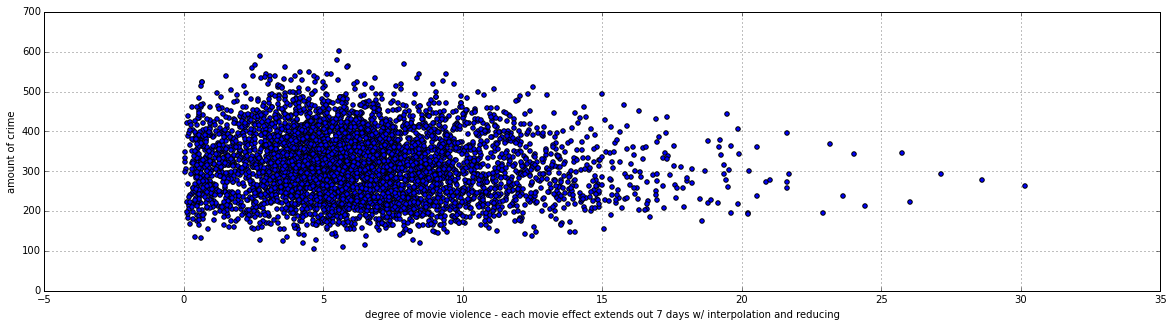

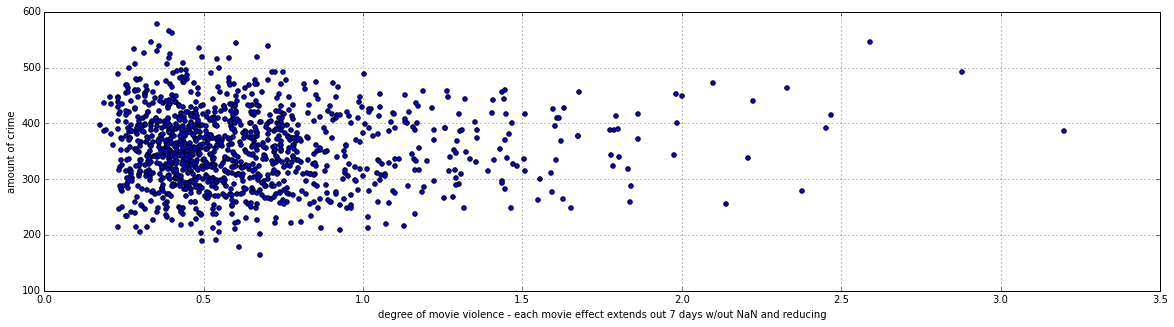

In [282]:
final_annoying_data = pd.DataFrame(v_movies_per_day).join(v_crimes_per_day).dropna()
ax = final_annoying_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,5))
ax.set_ylabel("amount of crime")
ax.set_xlabel("degree of movie violence - nan body count interpolated")

## nan body counts removed instead of interpolated
no_nan_final_annoying_data = pd.DataFrame(no_nan_graph).join(v_crimes_per_day).dropna()
no_nan_ax = no_nan_final_annoying_data.plot(y='Primary Type', x="violence index", kind = "scatter", figsize=(20,5))
no_nan_ax.set_ylabel("amount of crime")
no_nan_ax.set_xlabel("degree of movie violence - nan body count removed")

## nan body counts converted to 1
nan_1_final_annoying_data = pd.DataFrame(nan_1_graph).join(v_crimes_per_day).dropna()
nan_1_ax = nan_1_final_annoying_data.plot(y='Primary Type', x="violence index", kind = "scatter", figsize=(20,5))
nan_1_ax.set_ylabel("amount of crime")
nan_1_ax.set_xlabel("degree of movie violence - nan body count converted to 1")

## mean graph for movies instead of sum of movie index per day
mean_annoying_data = pd.DataFrame(mean_graph).join(v_crimes_per_day).dropna()
mean_ax = mean_annoying_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,5))
mean_ax.set_ylabel("amount of crime")
mean_ax.set_xlabel("degree of movie violence - mean daily movie index instead of sum")

## each movies stands alone instead of sum of movie index per day
stand_alone_annoying_data = pd.DataFrame(stand_alone_graph).join(v_crimes_per_day).dropna()
stand_alone_ax = stand_alone_annoying_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,5))
stand_alone_ax.set_ylabel("amount of crime")
stand_alone_ax.set_xlabel("degree of movie violence - each movie stands alone instead of sum")

## each movie violence index extends out seven days with interpolation
five_day_data = pd.DataFrame(five_day_graph_i).join(v_crimes_per_day).dropna()
five_day_ax = five_day_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,5))
five_day_ax.set_ylabel("amount of crime")
five_day_ax.set_xlabel("degree of movie violence - each movie effect extends out 7 days w/ interpolation")

## each movie violence index extends out seven days with nan values removed
five_day_data_no_nan = pd.DataFrame(five_day_graph_no_nan).join(v_crimes_per_day).dropna()
five_day_no_nan_ax = five_day_data_no_nan.plot(y='Primary Type', x="violence index", kind = "scatter", figsize=(20,5))
five_day_no_nan_ax.set_ylabel("amount of crime")
five_day_no_nan_ax.set_xlabel("degree of movie violence - each movie effect extends out 7 days w/out NaN")

## each movie violence index extends out seven days with interpolation and reduces
seven_day_data = pd.DataFrame(seven_day_graph_i).join(v_crimes_per_day).dropna()
seven_day_ax = seven_day_data.plot(y='Primary Type', x="reducing implied violence index", kind = "scatter", figsize=(20,5))
seven_day_ax.set_ylabel("amount of crime")
seven_day_ax.set_xlabel("degree of movie violence - each movie effect extends out 7 days w/ interpolation and reducing")

## each movie violence index extends out seven days with nan values removed and reduces
seven_day_data_no_nan = pd.DataFrame(seven_day_graph_no_nan).join(v_crimes_per_day).dropna()
seven_day_no_nan_ax = seven_day_data_no_nan.plot(y='Primary Type', x="reducing violence index", kind = "scatter", figsize=(20,5))
seven_day_no_nan_ax.set_ylabel("amount of crime")
seven_day_no_nan_ax.set_xlabel("degree of movie violence - each movie effect extends out 7 days w/out NaN and reducing")

In [191]:
X=final_annoying_data['implied violence index']
Y=final_annoying_data['Primary Type']

# final_annoying_data

In [192]:
results = sm.OLS( Y, X).fit()
results.summary()
# plt.scatter(X,Y)
# X_plot = np.linspace(0,1,100)
# plt.plot(X_plot, X_plot*results.params[0] + results.params[1])
# plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Primary Type   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     1650.
Date:                Wed, 22 Apr 2015   Prob (F-statistic):          1.73e-237
Time:                        11:08:26   Log-Likelihood:                -9329.6
No. Observations:                1373   AIC:                         1.866e+04
Df Residuals:                    1372   BIC:                         1.867e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
implied violence index    40.2118      0.990     40.616      0.000        38.270    42.154
==============================================================================
Omnibus:                       82.839   Durbin-Watson:                   1.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.476
Skew:                          -0.652   Prob(JB):                     6.81e-22
Kurtosis:                       2.966   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [193]:
## no nan body count
no_nan_X=no_nan_final_annoying_data['violence index'].dropna()
no_nan_Y=no_nan_final_annoying_data['Primary Type'].dropna()
no_nan_results = sm.OLS( no_nan_Y, no_nan_X).fit()
no_nan_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Primary Type   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     687.3
Date:                Wed, 22 Apr 2015   Prob (F-statistic):           1.56e-63
Time:                        11:08:30   Log-Likelihood:                -1189.0
No. Observations:                 182   AIC:                             2380.
Df Residuals:                     181   BIC:                             2383.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
violence index   360.8508     13.764     26.217      0.000       333.692   388.010
==============================================================================
Omnibus:                       39.610   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.008
Skew:                          -1.140   Prob(JB):                     1.26e-14
Kurtosis:                       4.801   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [247]:
## nan body count set to 1
nan_1_X=nan_1_final_annoying_data['violence index'].dropna()
nan_1_Y=nan_1_final_annoying_data['Primary Type'].dropna()
nan_1_results = sm.OLS( nan_1_Y, nan_1_X).fit()
nan_1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Primary Type   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     1651.
Date:                Wed, 22 Apr 2015   Prob (F-statistic):          1.20e-237
Time:                        11:38:02   Log-Likelihood:                -9329.2
No. Observations:                1373   AIC:                         1.866e+04
Df Residuals:                    1372   BIC:                         1.867e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
violence index    44.4652      1.094     40.636      0.000        42.319    46.612
==============================================================================
Omnibus:                       83.286   Durbin-Watson:                   1.253
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.086
Skew:                          -0.655   Prob(JB):                     5.02e-22
Kurtosis:                       2.975   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""